# **Recurrent Neural Networks (RNNs)**

Introduction to Recurrent Neural Networks (RNNs)
RNNs are a type of neural network designed for sequential data.

They have memory, allowing information to persist over time.

Used in applications like language modeling, speech recognition, and time series forecasting.

**📌 Key Concepts:**

Sequence data handling

Hidden states maintain information over time

Backpropagation Through Time (BPTT) for training

# **Recurrent Neural Networks (RNNs) - Teaching Notes**

---

**🔁 1. Introduction to Recurrent Neural Networks**

### 📖 Concept
Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed for sequential data. Unlike feedforward networks, RNNs maintain a hidden state that captures information from previous time steps, enabling them to model temporal dependencies.

### 🔬 Use Cases
- Time series prediction
- Natural language processing
- Speech and handwriting recognition

# **Libraries for RNN**

We import **numpy** & **pandas** for data, **matplotlib** & **seaborn** for plots, **sklearn** for splitting data and evaluation, and **TensorFlow/Keras** layers (`Sequential`, `Embedding`, `SimpleRNN`, `Dense`, `Dropout`) to build the RNN model.


In [80]:
import numpy as np,re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# **Dataset Description**
We are using the **UCI Promoter Gene Sequences Dataset**, which contains **53 promoter** and **53 non-promoter DNA sequences**.  

- Each DNA sequence is about **57 nucleotides long**.  
- **Labels**:  
  - `1 → Promoter`  
  - `0 → Non-Promoter`  
- The dataset is **balanced** (equal promoters & non-promoters).

# **Loading and Parsing DNA Sequence Data**

We read the file `/content/promoters.data`, ignore empty lines and comments, and extract **labels** and **DNA sequences**.  

- Labels like `+1`, `pos`, `positive` → `1`, and `-1`, `neg`, `negative` → `0`.  
- Sequences are cleaned of extra spaces.  

Finally, we print **total samples**, **label counts**, and a **sample parsed sequence**.


In [81]:
path = "/content/promoters.data"   # <-- your file

raw = []
with open(path, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        raw.append(line)

print("Sample raw lines:\n", "\n".join(raw[:3]), "\n")

labels, sequences = [], []
for ln in raw:
    parts = [p.strip() for p in ln.split(",")]

    label_str = parts[0].replace(" ", "")
    seq_field = parts[-1]
    seq = re.sub(r"\s+", "", seq_field)

    if label_str in {"+1", "1", "+", "pos", "positive"}:
        label = 1
    elif label_str in {"-1", "0", "-", "neg", "negative"}:
        label = 0
    else:
        raise ValueError(f"Unrecognized label: {label_str} in line: {ln}")

    labels.append(label)
    sequences.append(seq)

labels = np.array(labels)
print("Total samples:", len(sequences))
print("Unique labels (counts):", dict(zip(*np.unique(labels, return_counts=True))))
print("Example parsed:\n  label:", labels[0], "\n  seq  :", sequences[0][:70], "...\n")

Sample raw lines:
 +,S10,		tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt
+,AMPC,		tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaacgcatcgccaa
+,AROH,		gtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg 

Total samples: 106
Unique labels (counts): {np.int64(0): np.int64(53), np.int64(1): np.int64(53)}
Example parsed:
  label: 1 
  seq  : tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt ...



# **Encoding DNA Sequences**

- Map nucleotides `a, c, g, t` to integers `0-3`; unknown characters → `4`.  
- Convert each sequence to integer format and **pad sequences** to equal length.  
- Labels are converted to `int32`.  

Print shapes of **X (inputs)** and **y (labels)** to confirm.


In [82]:
vocab = {"a":0, "c":1, "g":2, "t":3}
UNK = 4

encoded = []
bad = 0
for s in sequences:
    s = s.lower()
    enc = [vocab.get(ch, UNK) for ch in s]

    if len(enc) == 0:
        bad += 1
    encoded.append(enc)

if bad:
    print(f"Warning: {bad} empty sequences encountered")

X = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")
y = labels.astype("int32")
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (106, 57) y shape: (106,)


# **Train-Test Split**

- Ensure labels are only `0` and `1`.  
- Split data into **training (80%)** and **testing (20%)** sets with **stratification** to keep label distribution consistent.


In [83]:
assert set(np.unique(y)) == {0,1}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# **Building the RNN Model**

- **Embedding layer**: Converts integer-encoded DNA to dense vectors.  
- **SimpleRNN layers**: Capture sequence patterns (64 → 32 units) with `tanh` activation.  
- **Dropout**: 30% to prevent overfitting.  
- **Dense layers**: 16-unit ReLU layer followed by **sigmoid output** for binary classification.  
- Compile with **Adam optimizer** and **binary crossentropy loss**, tracking **accuracy**.


In [84]:

seq_len = X.shape[1]
model = Sequential([
    Embedding(input_dim=5, output_dim=16, input_length=seq_len),
    SimpleRNN(64, return_sequences=True, activation="tanh"),
    Dropout(0.3),
    SimpleRNN(32, activation="tanh"),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# **Training the RNN**

- Use **EarlyStopping** to stop training if **validation loss** doesn’t improve for 6 epochs.  
- Train on **X_train/y_train**, validate on **X_test/y_test** for **20 epochs** with batch size 8.  
- Restore the **best weights** automatically to prevent overfitting.


In [86]:
es = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=8, callbacks=[es], verbose=1
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8559 - loss: 0.4237 - val_accuracy: 0.7727 - val_loss: 0.4777
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9017 - loss: 0.2948 - val_accuracy: 0.6818 - val_loss: 0.4943
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9243 - loss: 0.2319 - val_accuracy: 0.7273 - val_loss: 0.4677
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9634 - loss: 0.1902 - val_accuracy: 0.8182 - val_loss: 0.5129
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9357 - loss: 0.1795 - val_accuracy: 0.8182 - val_loss: 0.4908
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9372 - loss: 0.1609 - val_accuracy: 0.7727 - val_loss: 0.4694
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9860 - loss: 0.1346 - val_accuracy: 0.7727 - val_loss: 0.3708
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9930 - loss: 0.1029 - val_accuracy: 0.8182 - v

# **Evaluating the Model**

- Predict probabilities on **X_test** and convert to binary labels (`0/1`).  
- Print **classification report** showing precision, recall, F1-score.  
- Plot **confusion matrix** with Seaborn to visualize correct and incorrect predictions.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Classification report
               precision    recall  f1-score   support

Non-Promoter       0.80      0.73      0.76        11
    Promoter       0.75      0.82      0.78        11

    accuracy                           0.77        22
   macro avg       0.78      0.77      0.77        22
weighted avg       0.78      0.77      0.77        22



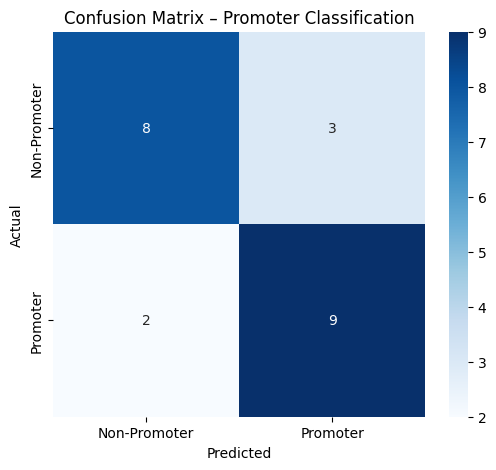

In [87]:
probs = model.predict(X_test).ravel()
y_pred = (probs >= 0.5).astype("int32")

print("\nClassification report\n", classification_report(y_test, y_pred, target_names=["Non-Promoter","Promoter"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Promoter","Promoter"],
            yticklabels=["Non-Promoter","Promoter"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix – Promoter Classification")
plt.show()

# **📈 Training Curves**

- Plot **accuracy** and **loss** for both training and validation sets over epochs.  
- Helps visualize **model performance** and check for **overfitting or underfitting**.


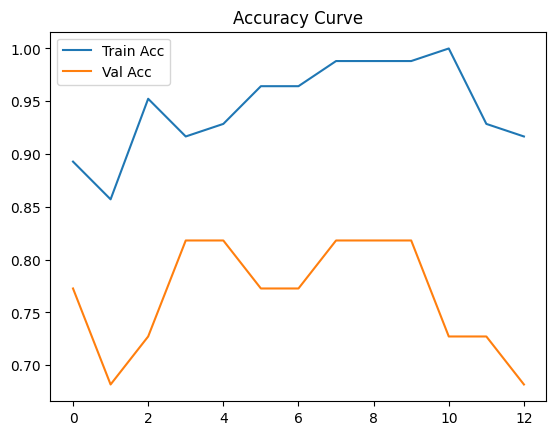

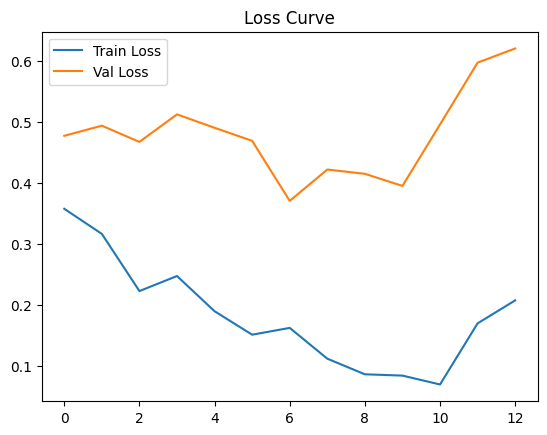

In [88]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# **Final Model Evaluation**

- Evaluate the model on **test data** to get final **loss** and **accuracy**.  
- Print **test accuracy** as a percentage.


In [95]:
loss, acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {acc:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7727 - loss: 0.3708
 Final Test Accuracy: 77.27%


# **Predicting New DNA Sequences**

- Define `predict_sequence` to **encode, pad, and predict** a DNA sequence.  
- Outputs: **input snippet**, **probabilities for promoter/non-promoter**, and **final prediction**.  
- Example predictions are shown for two test sequences.


In [104]:
def predict_sequence(seq, model, maxlen):
    mapping = {"a": 0, "c": 1, "g": 2, "t": 3}
    encoded = [mapping[b] for b in seq.lower() if b in mapping]
    x = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=maxlen, padding="post")
    prob = model.predict(x, verbose=0)[0][0]

    print("DNA Sequence Test Result")
    print(f"🧬 Input Sequence: {seq[:50]}... (len={len(seq)})")
    print(f" Probability (Promoter): {prob:.2f}")
    print(f" Probability (Non-Promoter): {1-prob:.2f}")
    print(" Prediction:", "Promoter" if prob >= 0.5 else "Non-Promoter")


predict_sequence("tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt", model, X.shape[1])

predict_sequence("gtgctaatcgcgttaggccttatcgcttgcacgatcagcttgtgcttccggcgatat", model, X.shape[1])


DNA Sequence Test Result
🧬 Input Sequence: tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggc... (len=57)
 Probability (Promoter): 0.95
 Probability (Non-Promoter): 0.05
 Prediction: Promoter
DNA Sequence Test Result
🧬 Input Sequence: gtgctaatcgcgttaggccttatcgcttgcacgatcagcttgtgcttccg... (len=57)
 Probability (Promoter): 0.36
 Probability (Non-Promoter): 0.64
 Prediction: Non-Promoter
